<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-if-ready" data-toc-modified-id="Test-if-ready-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test if ready</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Paths</a></span></li><li><span><a href="#Create-SPEC-file-and-set-PD-savepath" data-toc-modified-id="Create-SPEC-file-and-set-PD-savepath-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create SPEC file and set PD savepath</a></span></li><li><span><a href="#Run-Direct-Beam-Scan" data-toc-modified-id="Run-Direct-Beam-Scan-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run Direct Beam Scan</a></span></li><li><span><a href="#Read-Files-from-Local-Computer" data-toc-modified-id="Read-Files-from-Local-Computer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Read Files from Local Computer</a></span></li><li><span><a href="#Get-Images-that-see-direct-beam" data-toc-modified-id="Get-Images-that-see-direct-beam-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Get Images that see direct beam</a></span></li><li><span><a href="#Fit-2D-Pvoigt-to-all-images" data-toc-modified-id="Fit-2D-Pvoigt-to-all-images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Fit 2D Pvoigt to all images</a></span></li><li><span><a href="#Create-and-save-PONI-file" data-toc-modified-id="Create-and-save-PONI-file-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Create and save PONI file</a></span></li></ul></div>

In [2]:
%matplotlib notebook

import sys, os, glob, imp, fnmatch, re
from copy import deepcopy

import matplotlib.pyplot as plt

import numpy as np
import scipy

from collections import OrderedDict

from ipywidgets import *
from IPython.display import display, Image

from lmfit import Model, Parameters
from lmfit.models import LinearModel, GaussianModel, PseudoVoigtModel

from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyFAI
from pyFAI.multi_geometry import MultiGeometry
from silx.io.specfile import SpecFile

from joblib import Parallel, delayed
import multiprocessing as mp

sys.path.append('C:\\Users\\Public\\repos\\xdart')
from xdart.utils import get_motor_val
from xdart.utils import get_from_pdi, query_yes_no, read_image_file, smooth_img, get_fit, fit_images_2D
from xdart.pySSRL_bServer.bServer_funcs import specCommand, wait_until_SPECfinished

import time
from pathlib import Path

## Test if ready

In [2]:
# Check if detector is ready for direct beam scan

ready = query_yes_no('Are filters in? Can detector take direct beam?')

if ready != 'yes':
    print('Cannot proceed with direct beam scan..')
    sys.exit()

Are filters in? Can detector take direct beam? [y/N] y


## Paths

In [3]:
remote_path = '~/data/calibration'
local_path = 'P:\\bl2-1\\calibration'
poni_path = 'P:\\bl2-1\\poni_files'

## Create SPEC file and set PD savepath

In [6]:
# Create SPEC folder if it doesn't exist
command = f'u mkdir {remote_path}'
specCommand(command)

# Create new calibration spec file with date time stamp
path = remote_path
spec_path = path

timestr = time.strftime("%Y%m%d-%H%M%S")
calibScan = f'calib_{timestr}'

print(f'Creating new SPEC file {calibScan} for calibration scan in {spec_path}..')
command = f'newfile {spec_path}/{calibScan}'
try:
    specCommand(command, queue=True)
except Exception as e:
    print(e)
    print(f"Command '{command}' not sent")
    sys.exit()    

Executed
Creating new SPEC file calib_20200218-155054 for calibration scan in ~/data/calibration..
SPEC busy. Command Queued
Executed


In [14]:
command = f'u mkdir {img_path}'
specCommand(command)

Executed


In [15]:
# Change PD Savepath
img_path = f'{path}/images'
pdi_path = img_path

command = f'u mkdir {img_path}'
specCommand(command)

print(f'Changing PD SavePath to {img_path}')
command = f'pd savepath {img_path}'
try:
    specCommand(command, queue=True)
except Exception as e:
    print(e)
    print(f"Command '{command}' not sent")
    sys.exit()
    
print(f'Now Saving images to {img_path}')
command = f'pd save'
try:
    specCommand(command, queue=True)
except Exception as e:
    print(e)
    print(f"Command '{command}' not sent")
    sys.exit()

Executed
Changing PD SavePath to ~/data/calibration/images
SPEC busy. Command Queued
Executed
Now Saving images to ~/data/calibration/images
SPEC busy. Command Queued
Executed


## Run Direct Beam Scan

In [21]:
def query(question):
    """Ask a question with allowed options via input()
    and return their answer.
    """
    sys.stdout.write(question)
    return input()
    
question = 'Enter rough detector sample distance in meters:'
rv = query('Enter rough detector sample distance in meters:')

Enter rough detector sample distance in meters:0.5


In [22]:
len(rv)

3

In [13]:
orientations = {'v': 'vertical',
                    'h': 'horizontal',
                    '': 'vertical'}

In [ ]:
detectors_dict = {'1': 'Pilatus100K',
             '2': 'Pilatus300K',
             '3': 'Eiger1M'}

question = 'Choose detector (1-3) [1] Pilatus100K (2) Pilatus300K (3) Eiger1M: '
det_number = query(question)
try:
    detector = detectors_dict[det_number]
except:
    print('Choice must be a number from (1 - 3)')

question = 'Detector orientation (v/h)'
options = '[v] vertical (h) horizontal: '

In [16]:
# Run Direct Beam Scan

init_dist = 0.7
pixel_sz = 0.000172

ccd_shape = (195, 487)
orientation = 'vertical'

if orientation == 'vertical':
    ccd_shape = (487, 195)

tth = np.round(np.rad2deg( np.arctan(pixel_sz*ccd_shape[0]/2 / init_dist) ) + 0.2, 1)
tth_range = [-tth, tth]

steps = len(np.arange(-tth, tth, 0.02))

command = f'ascan  tth -{tth} {tth} {steps} 1'
print(f'Running direct beam scan [{command}]')
try:
    specCommand(command, queue=True)
except Exception as e:
    print(e)
    print(f"Command '{command}' not sent")
    sys.exit()
    
# Wait till Scan is finished to continue
print('Waiting for scan to finish..')
wait_until_SPECfinished(polling_time=5)
time.sleep(5)
print('Done', '\n')

Running direct beam scan [ascan  tth -3.6 3.6 360 1]
Executed
Waiting for scan to finish..
Done 



## Read Files from Local Computer

In [20]:
# Read Spec File and get Image and PDI File Names

path = local_path

spec_path = path
spec_file = SpecFile( os.path.join(spec_path, f'{calibScan}') )

img_path = os.path.join(path, 'images')
pdi_path = img_path

img_fnames = sorted(fnmatch.filter(os.listdir(img_path), f'*{calibScan}*.raw'))
pdi_fnames = [f'{img_fname}.pdi' for img_fname in img_fnames
             if os.path.exists( os.path.join(pdi_path, f'{img_fname}.pdi') )]

if len(pdi_fnames) != len(img_fnames):
    print('PDI files for all images not present..')

## Get Images that see direct beam

In [24]:
# Get Range of TTh Values that see Direct Beam

def get_TTh_w_direct_beam(img_path, img_fnames, pdi_path, pdi_fnames):
    img_mean_vals = [ np.mean(read_image_file( os.path.join(img_path, img_fname),
                                              return_float=True ))
                     for img_fname in img_fnames]
    median_mean_vals = np.median( np.asarray(img_mean_vals) )

    TThs = OrderedDict()
    for (img_fname, pdi_fname) in zip(img_fnames, pdi_fnames):
        img = read_image_file( os.path.join(img_path, img_fname), return_float=True )
        if np.mean(img) > median_mean_vals/2.:
            tth = get_motor_val( os.path.join(pdi_path, pdi_fname), 'TwoTheta' )
            TThs[img_fname] = tth


    # Limit to TThs that have both positive and negative values
    while True:
        keys = list(TThs.keys())
        tths = np.asarray([tth for k, tth in TThs.items()])

        if abs(tths[0]) == abs(tths[-1]):
            break

        if np.abs(tths[0]) > tths[-1]:
            del TThs[keys[0]]
        else:
            del TThs[keys[-1]]

    n0 = len(tths)//2
    keys = keys[:20] + keys[n0-20 : n0+20] + keys[-20:]
    TThs = OrderedDict({k:TThs[k] for k in keys})
    return TThs

print('Getting all images that see direct beam')
TThs = get_TTh_w_direct_beam(img_path, img_fnames, pdi_path, pdi_fnames)

img_fnames = list(TThs.keys())
pdi_fnames = [f'{img_fname}.pdi' for img_fname in img_fnames]
tths = np.asarray([tth for k, tth in TThs.items()])
print(f'TTh range for direct beam: [{tths[0]}, {tths[-1]}]\n')

Getting all images that see direct beam
TTh range for direct beam: [-3.28, 3.28]



## Fit 2D Pvoigt to all images

In [25]:
# Fit All Images

def fit_all_images(img_path, img_fnames, tths, n_cores=None):
    if n_cores is None:
        n_cores = mp.cpu_count()
        
    fit_results = Parallel(n_jobs=n_cores) (
        delayed(fit_images_2D)(os.path.join(img_path, fname), tth, function='pvoigt',
                               kernel_size=3, window_size=1,
                               verbose='True', orientation='vertical', flip=False)
        for (fname, tth) in zip(img_fnames[::], tths[::]) )


    Fit_Results = OrderedDict ( { tth:fit_result for (tth, fit_result) in fit_results } )

    tths = np.asarray( list(Fit_Results.keys()) )
    xs = np.asarray( [Fit_Results[tth].params['center_x'] for tth in tths] )
    ys = np.asarray( [Fit_Results[tth].params['center_y'] for tth in tths] )
    
    return tths, xs, ys

print('Fitting 2D PVoigt to all images..')
tths, xs, ys =  fit_all_images(img_path, img_fnames, tths)
print('Done \n')

Fitting 2D PVoigt to all images..


C:\Users\Public\miniconda3\envs\xdart\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Done 



In [28]:
# Get direct beam pixel at TTh = 0 degrees

def get_db_pixel(tths, xs, ys):
    n0 = len(tths)//2
    s_ = np.s_[n0-20 : n0+20]

    xs, ys, tths = xs[s_], ys[s_], tths[s_]

    mod_xs = LinearModel()
    params_xs = mod_xs.guess(xs, x=tths)
    fit_xs = mod_xs.fit(xs, params=params_xs, x=tths)
    fit_xs = mod_xs.fit(xs, params=fit_xs.params, x=tths)

    mod_ys = LinearModel()
    params_ys = mod_ys.guess(ys, x=tths)
    fit_ys = mod_ys.fit(ys, params=params_ys, x=tths)
    fit_ys = mod_ys.fit(ys, params=fit_ys.params, x=tths)

    x0 = fit_xs.eval(params=fit_xs.params, x=0.0)
    y0 = fit_ys.eval(params=fit_ys.params, x=0.0)

    return x0, y0

print('Obtaining direct beam pixel at TTh=0')
x0, y0 = get_db_pixel(tths, xs, ys)
print(f'Direct beam pixel at TTh=0: [{x0:.2f}, {y0:.2f}]\n')

Obtaining direct beam pixel at TTh=0
Direct beam pixel at TTh=0: [98.80, 249.10]



In [31]:
tths

array([-3.28, -3.26, -3.24, -3.22, -3.2 , -3.18, -3.16, -3.14, -3.12,
       -3.1 , -3.08, -3.06, -3.04, -3.02, -3.  , -2.98, -2.96, -2.94,
       -2.92, -2.9 , -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 , -0.28,
       -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12, -0.1 ,
       -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,
        0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,  0.26,
        0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  2.9 ,  2.92,  2.94,
        2.96,  2.98,  3.  ,  3.02,  3.04,  3.06,  3.08,  3.1 ,  3.12,
        3.14,  3.16,  3.18,  3.2 ,  3.22,  3.24,  3.26,  3.28])

Calculating PONI File parameters (dist, rot2, rot3, poni1, poni2)
OrderedDict([('dist', 0.7084968836405228), ('rot2', 0.0028064294240650275), ('rot3', 0.002545413976945955), ('poni1', 0.04085652684787848), ('poni2', 0.016998072688000482)])


<IPython.core.display.Javascript object>


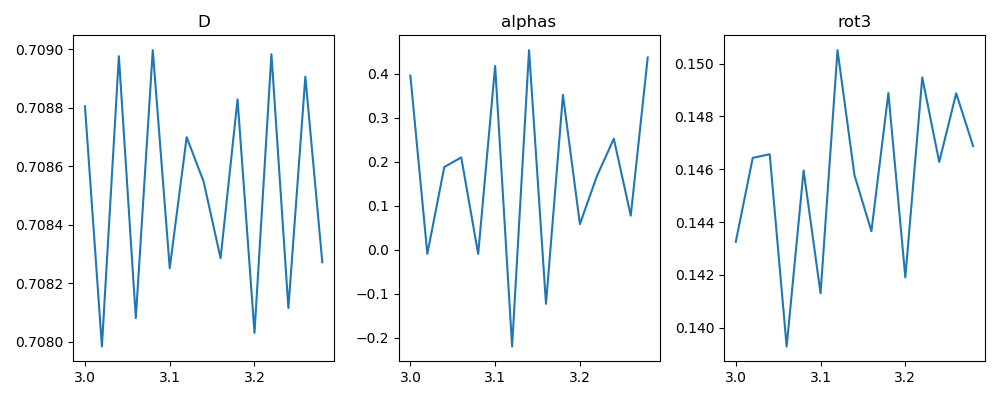

In [35]:
def get_poni_params(tths, xs, ys, x0, y0, pixel_sz=0.000172):
    xs = np.round(xs, 2)
    ys = np.round(ys, 2)
    
    n0 = len(tths)//2; tth0 = tths[n0]

    xys = []
    ds, Ds, alphas, rot3s, all_tths = [], [], [], [], []
    for ii in range(0, n0):
        idx1, idx2 = ii, -ii-1
        tth1, tth2 = tths[idx1], tths[idx2]
        
        if abs(tth1) < 3:
            continue

        if tth1 != -tth2:
            print(f'tth1 ({tth1}) != -tth2 ({tth2})')
            break
            
        x1, x2 = xs[idx1], xs[idx2]
        y1, y2 = ys[idx1], ys[idx2]

        xys.append(np.asarray([x1, y1, x2, y2]))

        d1 = np.sqrt( (x1 - x0)**2 + (y1 - y0)**2 ) * pixel_sz
        d2 = np.sqrt( (x2 - x0)**2 + (y2 - y0)**2 ) * pixel_sz

        ds.append(np.asarray([d1, d2]))

        tth = np.deg2rad (abs(tth1))

        D = 2 * d1 * d2 * (d1 + d2) * np.tan(tth) / (
            (d1 + d2)**2 * np.tan(tth)**2  + (d1 - d2)**2 )

        alpha = - np.arctan( 1/np.tan(tth) * (d1 - d2) / (d1 + d2) )
        rot3 = - (x1 - x2) / (y1 - y2)

        Ds.append(D)
        alphas.append(alpha)
        rot3s.append(rot3)
        all_tths.append( np.rad2deg(tth) )

    D = np.mean(Ds[:-1])
    rot2 = np.mean(alphas[:-1])
    rot3 = np.mean(rot3s[:-1])

    poni1 = y0 * pixel_sz - D*np.tan(rot2)*np.cos(rot3)
    poni2 = x0 * pixel_sz + D*np.tan(rot2)*np.sin(rot3)
    #poni1 = (485-y0) * pixel_sz + D*np.tan(rot2)*np.cos(rot3)# + 0.005

    poni_params = OrderedDict(dist=D, rot2=rot2, rot3=rot3, poni1=poni1, poni2=poni2)
    print(poni_params)
    
    fig, axs = plt.subplots(ncols=3, figsize=(10,4))
    axs[0].plot(all_tths, Ds[:])
    axs[0].set_title('D')

    axs[1].plot(all_tths, np.rad2deg(alphas[:]))
    axs[1].set_title('alphas')

    axs[2].plot(all_tths, np.rad2deg(rot3s[:]))
    axs[2].set_title('rot3')
    fig.tight_layout()

    return poni_params

# Obtain Poni Parameters
print('Calculating PONI File parameters (dist, rot2, rot3, poni1, poni2)')
poni_params = get_poni_params(tths, xs, ys, x0, y0, pixel_sz=pixel_sz)

## Create and save PONI file

In [36]:
def make_poni(poni_file, spec_file, params, detector="Pilatus100k"):
    energy = spec_file.motor_position_by_name(0, 'Monochrom')
    wavelength = 12398/energy * 1e-10
    print(f'Energy: {energy}, Wavelength: {wavelength}')

    poni_params = dict(
        detector = detector,
        wavelength = wavelength,
        **params
    )

    ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(**poni_params)
    ai.save(os.path.join(poni_path, f'{calibScan}.poni'))
    print(ai)
    
    
poni_file = os.path.join(poni_path, f'{calibScan}.poni')
print(f'Making and saving {poni_file}')
make_poni(poni_file, spec_file, poni_params, detector=detector)

Making and saving P:\bl2-1\poni_files\calib_20200218-155054.poni
Energy: 7722.9985, Wavelength: 1.6053350262854514e-10
Detector Pilatus 100k	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.605335e-10m
SampleDetDist= 7.084969e-01m	PONI= 4.085653e-02, 1.699807e-02m	rot1=0.000000  rot2= 0.002806  rot3= 0.002545 rad
DirectBeamDist= 708.500mm	Center: x=98.826, y=249.098 pix	Tilt=0.161 deg  tiltPlanRotation= 90.000 deg


In [9]:
detector = pyFAI.detector_factory('Pilatus100K')

In [12]:
detector.max_shape

(195, 487)

In [ ]:
    valid = {"yes":"yes",   "y":"yes",  "ye":"yes",
             "no":"no",     "n":"no"}
    if default == None:
        prompt = " [y/n] "
    elif default == "yes":
        prompt = " [Y/n] "
    elif default == "no":
        prompt = " [y/N] "
    else:
        raise ValueError("invalid default answer: '%s'" % default)

    while 1:
        sys.stdout.write(question + prompt)
        choice = input().lower()
        if default is not None and choice == '':
            return default
        elif choice in valid.keys():
            return valid[choice]
        else:
            sys.stdout.write("Please respond with 'yes' or 'no' "\
                             "(or 'y' or 'n').\n")

In [ ]:
def get_poni_params(tths, xs, ys, x0, y0, pixel_sz=0.000172):
    xs = np.round(xs, 2)
    ys = np.round(ys, 2)
    
    n0 = len(tths)//2; tth0 = tths[n0]

    xys = []
    ds, Ds, alphas, rot3s, all_tths = [], [], [], [], []
    for ii in range(0, n0):
        idx1, idx2 = ii, -ii-1
        tth1, tth2 = tths[idx1], tths[idx2]
        
        if abs(tth1) < 2.5:
            continue

        if tth1 != -tth2:
            print(f'tth1 ({tth1}) != -tth2 ({tth2})')
            break
            
        x1, x2 = xs[idx1], xs[idx2]
        y1, y2 = ys[idx1], ys[idx2]

        xys.append(np.asarray([x1, y1, x2, y2]))

        d1 = np.sqrt( (x1 - x0)**2 + (y1 - y0)**2 ) * pixel_sz
        d2 = np.sqrt( (x2 - x0)**2 + (y2 - y0)**2 ) * pixel_sz

        ds.append(np.asarray([d1, d2]))

        tth = np.deg2rad (abs(tth1))

        D = 2 * d1 * d2 * (d1 + d2) * np.tan(tth) / (
            (d1 + d2)**2 * np.tan(tth)**2  + (d1 - d2)**2 )

        alpha = - np.arctan( 1/np.tan(tth) * (d1 - d2) / (d1 + d2) )
        rot3 = - (x1 - x2) / (y1 - y2)

        Ds.append(D)
        alphas.append(alpha)
        rot3s.append(rot3)
        all_tths.append( np.rad2deg(tth) )

    ds = np.asarray(ds); xys = np.asarray(xys)
    d1, d2 = ds[:,0], ds[:,1] 

    fig, axs = plt.subplots(ncols=4, figsize=(12,4))
    axs[0].plot(all_tths, d1-d2)
    axs[0].set_title('d1 - d2')

    axs[1].plot(all_tths, Ds[:])
    axs[1].set_title('D')

    axs[2].plot(all_tths, np.rad2deg(alphas[:]))
    axs[2].set_title('alphas')

    axs[3].plot(all_tths, np.rad2deg(rot3s[:]))
    axs[3].set_title('rot3')
    fig.tight_layout()

    D = np.mean(Ds[:-1])
    rot2 = np.mean(alphas[:-1])
    rot3 = np.mean(rot3s[:-1])

    poni1 = y0 * pixel_sz - D*np.tan(rot2)*np.cos(rot3)
    poni2 = x0 * pixel_sz + D*np.tan(rot2)*np.sin(rot3)
    #poni1 = (485-y0) * pixel_sz + D*np.tan(rot2)*np.cos(rot3)# + 0.005

    print(D, rot2, rot3, poni1, poni2)
    return D, rot2, rot3, poni1, poni2
 
D, rot2, rot3, poni1, poni2 = get_poni_params(tths, xs, ys, x0, y0, pixel_sz=0.000172)